**statsmodels** : 선형 회귀, 로지스틱 회쉬 및 시계열 분석 등의 통계 검정이나 모델링과 관련된 풍부한 기능 제공   
**pasty** : R과 같은 통계 소프트웨어에서 영감을 얻어 간단한 유형 언어로 통계 모델링을 정의할 수 있는 기능 제공

## 모델 임포트하기

In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## 통계 모델링 소개
반응 변수의 집홥 Y와 설명 변수의 집합 X로 Y와 X 사이의 수학적 관계 찾기   
-> 모델을 통계적으로 만드는 핵심 구성 요소는 데이터가 잡음 등의 상황으로 인해 불확실성 요소를 갖기 때문   
데이터의 불확실성은 모델에서의 확률 변수로 묘사 가능   
널리 사용되는 통계 모델: **Y = ß<sub>0</sub>+ß<sub>1</sub> X+e**
- 잔차 e는 정규분포하므로 **최소 자승법**으로 모델을 데이터에 적합화 가능


## Patsy를 이용한 통계 모델 정의
1. 모델의 수학적 형태 확립
2. 회귀 문제가 행렬 유형으로 나타나는 소위 설계 행렬 y와 X 구성

아래의 예시는 두 독립 변수 x1, x2에 해당하는 관측값이 y이고 고려 중인 선형 모델이 Y = ß<sub>o</sub> + ß<sub>I</sub>X<sub>l</sub> + ß<sub>2</sub>X<sub>2 </sub>이면 설계 행렬은 X= [1 , X<sub>1</sub> ,X<sub>2</sub>, x<sub>1</sub>x<sub>2</sub>] 가 됨

In [53]:
y = np.array([1, 2, 3, 4, 5])
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T
X # 설계 행렬

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [54]:
# X와 y가 주어지면 최소 지승 적합화를 이용해 미지 계수 벡터 ß찾기
beta, res, rank, sval = np.linalg.lstsq(X, y)
beta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -1.11022302e-15])

Pasty는 모델을 정의하고 관련 설계 행렬을 자동으로 구성하기에 편리한 유형의 언어 제공   
**Y = ß<sub>o</sub> + ß<sub>I</sub>X<sub>l</sub> + ß<sub>2</sub>X<sub>2 </sub> 를 Pasty로 정의하면**   
-> "y ~ 1 + x1 + x2 + x1*x2"와 같이 공식 문자열을 작성해야 함


In [55]:
data = {"y": y, "x1": x1, "x2": x2}
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data)
y 

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [56]:
X

DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

In [57]:
type(X) # DesignMatrix 유형

patsy.design_info.DesignMatrix

In [58]:
np.array(X) # DesignMatrix 인스턴스를 ndarray 객체로 변환하기

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [59]:
df_data = pd.DataFrame(data)
# return type을 지정함으로써 DataFrame 객체 형태로 설계 행렬 반환
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1:x2", df_data, return_type="dataframe")
X

,Intercept,x1,x2,x1:x2
0,1.0,6.0,11.0,66.0
1,1.0,7.0,12.0,84.0
2,1.0,8.0,13.0,104.0
3,1.0,9.0,14.0,126.0
4,1.0,10.0,15.0,150.0


**선형 회귀**를 수행하려면 **statsmodels 라이브러리의 OLS 클래스**를 사용

In [60]:
model = sm.OLS(y, X)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

In [61]:
# statsmodels 공식 API를 이용하면 Pasty 공식 직접 전달 가능
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

**Pasty 공식의 구문과 표기**
- 좌변(LHS): 반응 변수를 구성하는 항 지정
- 우변(RHS): 설명 변수를 구성하는 항 지정 

In [62]:
from collections import defaultdict
data = defaultdict(lambda: np.array([]))
patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names

['Intercept', 'a']

In [63]:
patsy.dmatrices("y ~ 1 + a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [64]:
# -1로 절편 제거
patsy.dmatrices("y ~ -1 + a + b", data=data)[1].design_info.term_names

['a', 'b']

In [65]:
# a * b는 모든 하위 차수 상호 작용 항을 포함하도록 자동 확장
patsy.dmatrices("y ~ a * b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b']

In [66]:
# 더 고차로 확장
patsy.dmatrices("y ~ a * b * c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c', 'a:b:c']

In [67]:
# -를 이용하여 특정 항 제거
patsy.dmatrices("y ~ a * b * c - a:b:c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c']

Pasty에서 +와 -는 집합 연산자와 같은 역할    
-> 산술식으로 표현해야 하는 경우 함수 호출로 식을 둘러싸야 함    
-> 편의상 **I라는 항등 함수** 제공

In [68]:
data = {k: np.array([]) for k in ["y", "a", "b", "c"]}
patsy.dmatrices("y ~ a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [69]:
# 항등함수
# I(a + b) 는 a와 b의 산술 합
patsy.dmatrices("y ~ I(a + b)", data=data)[1].design_info.term_names

['Intercept', 'I(a + b)']

In [70]:
patsy.dmatrices("y ~ a**2", data=data)[1].design_info.term_names

['Intercept', 'a']

In [71]:
# 변수의 지수로 표현되는 항 포함
patsy.dmatrices("y ~ I(a**2)", data=data)[1].design_info.term_names

['Intercept', 'I(a ** 2)']

In [72]:
# numpy 사용하여 입력 데이터 배열 변환
patsy.dmatrices("y ~ np.log(a) + b", data=data)[1].design_info.term_names

['Intercept', 'np.log(a)', 'b']

In [73]:
# 변수에 임의의 python 함수를 사용해 변환
z = lambda x1, x2: x1+x2
patsy.dmatrices("y ~ z(a, b)", data=data)[1].design_info.term_names

['Intercept', 'z(a, b)']

"y ~ - 1 + a" 와 "y ~ - 1 + C(a)"에 해당하는 설계 행렬 살펴보기   
-> a는 각각 **수치**인 경우와 **범주형**인 경우 

In [74]:
# 수치 변수
data = {"y": [1, 2, 3], "a": [1, 2, 3]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a
0,1.0
1,2.0
2,3.0


In [75]:
# 범주형 변수 -> 개별 값에서 마스크처럼 인코딩한 새로운 이진 열 추가
patsy.dmatrices("y ~ - 1 + C(a)", data=data, return_type="dataframe")[1]

,C(a)[1],C(a)[2],C(a)[3]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [76]:
# 비수치값 변수는 자동으로 변수형으로 해석해 처리
data = {"y": [1, 2, 3], "a": ["type A", "type B", "type C"]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a[type A],a[type B],a[type C]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [77]:
# 범주형 변수의 인코딩 유형은 변경 가능
# C(a, Poly)의 경우 직교 다항식
patsy.dmatrices("y ~ - 1 + C(a, Poly)", data=data, return_type="dataframe")[1]

,"C(a, Poly).Constant","C(a, Poly).Linear","C(a, Poly).Quadratic"
0,1.0,-7.071068e-01,0.408248
1,1.0,-5.551115e-17,-0.816497
2,1.0,7.071068e-01,0.408248


## 선형 회귀
**statsmodel로 통계 모델 설정하고 분석하는 기본 작업 흐름**
1. 모델 클래스의 인스턴스 생성
2. fit 메서드를 이용해 적합화 수행
3. fit 메서드가 반환한 결과 객체의 요약 통계량 출력
4. 모델 적합화 결과 후처리
5. 적합화 결과 시각화

실제 값이 y = 1 + 2x<sub>I</sub> + 3x<sub>2</sub> + 4x<sub>I</sub>x<sub>2</sub>인 모델에서 생성된 데이터 적합화하기

In [78]:
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})
def y_true(x1, x2):
    return 1  + 2 * x1 + 3 * x2 + 4 * x1 * x2

data["y_true"] = y_true(x1, x2)

e = 0.5 * np.random.randn(N)
data["y"] = data["y_true"] + e # 참 값에 정규분포하는 잡음 추가

model = smf.ols("y ~ x1 + x2", data) # 반응 변수는 연속적이므로 최소 자승 사용
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     57.74
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           3.05e-17
Time:                        04:24:59   Log-Likelihood:                -266.62
No. Observations:                 100   AIC:                             539.2
Df Residuals:                      97   BIC:                             547.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6366      0.359      1.774      0.0

**R-제곱값**: 0~1 사이 값이며 1에 가까울수록 완벽히 적합화 된다는 뜻    
**coef 칼럼** : 적합화된 모델 매개변수를 보여줌

In [79]:
result.rsquared

0.5434689230696133

In [80]:
# 오차가 정규분포한다는 가정이 정당한지 모델의 잔차 살펴보기
result.resid.head()

0    0.183198
1   -0.370983
2   -0.756723
3    0.440228
4   -2.043042
dtype: float64

In [81]:
# 잔차를 이용해 normaltest 함수 사용하면 정규성 확인 가능
z, p = stats.normaltest(result.resid.values)
p

1.7347101205823256e-06

이 예제의 결과 p가 매우 작기 때문에 잔차가 정규분포한다는 귀무 가설 기각 가능

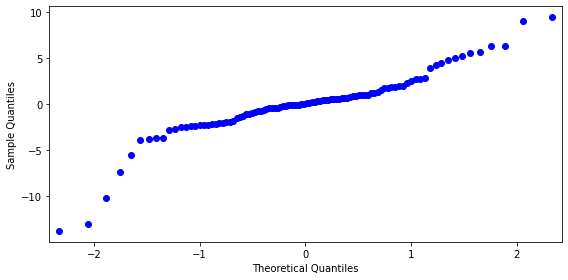

In [82]:
# 표본의 정규성 검사
# 표본이 실제로 정규분포 한다면 직선에 가까워야 함
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)
fig.tight_layout()

위의 그래프 결과 관측된 잔차가 정규 분포 확률 변수의 표본일 가능성이 낮음   
-> 다시 이전 분석 단계 반복하기

In [83]:
model = smf.ols("y ~ x1 + x2 + x1*x2", data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2967.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.77e-94
Time:                        04:25:00   Log-Likelihood:                -78.814
No. Observations:                 100   AIC:                             165.6
Df Residuals:                      96   BIC:                             176.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0220      0.055     18.424      0.0

R-제곱 통계량이 0.9916로 상당히 높으므로 모델과 데이터 사이에 완벽한 일치가 나타남

In [84]:
result.rsquared

0.9893290940467027

In [85]:
z, p = stats.normaltest(result.resid.values)
p

0.4355606789006228

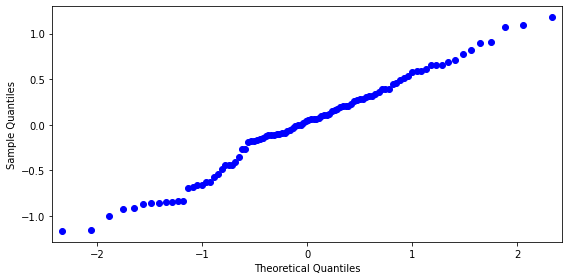

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)

fig.tight_layout()

In [87]:
# 모델의 적합도에 만족한다면 params 속성을 사용해 모델 계수 추출
result.params

Intercept    1.021981
x1           2.032800
x2           3.012726
x1:x2        4.019227
dtype: float64

In [88]:
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x)
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()})
y_pred = result.predict(new_data) # 예측
y_pred.shape

(2500,)

In [89]:
# 도식화 하기 위해 크기를 정방 행렬로 조정
y_pred = y_pred.values.reshape(50, 50)

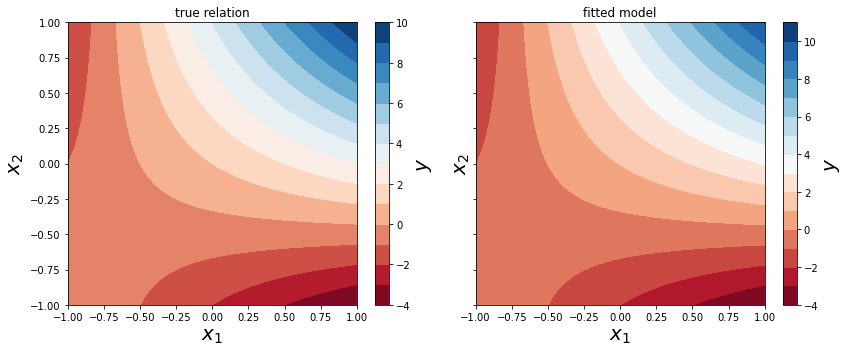

In [90]:
# 참 모델과 참 모델에 정규분포하는 노이즈를 추가한 100개 표본에 적합화한 모델
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], y_pred, "fitted model")

fig.tight_layout()

## 예제 데이터셋

In [91]:
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat")
dataset.title

'Ice Cream Consumption'

In [92]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cons    30 non-null     float64
 1   income  30 non-null     int64  
 2   price   30 non-null     float64
 3   temp    30 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.1 KB


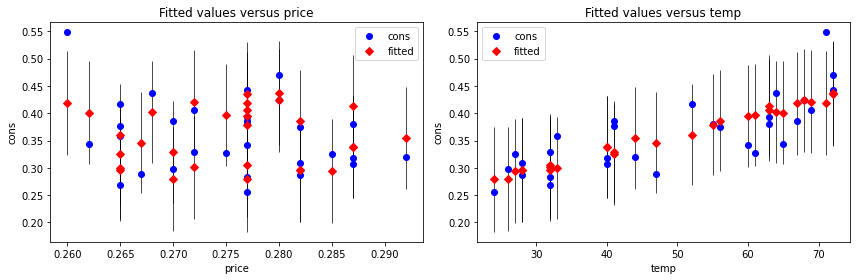

In [93]:
# 가격과 기온을 독립 변수로 하는 선형 모델로 소비량을 모델링
model = smf.ols("cons ~ -1 + price + temp", data=dataset.data)
result = model.fit()

# 회귀 그래프 도식화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
smg.plot_fit(result, 0, ax=ax1)
smg.plot_fit(result, 1, ax=ax2)

fig.tight_layout()

그림의 결과 Icecream 데이터셋에서 **소비와 기온은 선형적으로 상관 관계가 있는 것**으로 보이지만 가격에 대한 종속성은 명확하지 않음

## 이산 회귀 분석
적절한 변환을 사용하여 선형 예측 변수를 다른 이산 결과의 확률로 해석할 수 있는 구간으로 **매핑**하기

### 로지스틱 회귀


In [94]:
df = sm.datasets.get_rdataset("iris").data # 붓꽃 데이터셋
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [95]:
df.Species.unique() # Species 열의 고유한 종 유형 개수

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [96]:
# 이항 변수를 구하기 위해 versicolor, virginica 두 종 데이터만 초점 맞추기
df_subset = df[df.Species.isin(["versicolor", "virginica"])].copy()

# 이진값 0과 1로 매핑
df_subset.Species = df_subset.Species.map({"versicolor": 1, "virginica": 0})

df_subset.rename(columns={"Sepal.Length": "Sepal_Length", "Sepal.Width": "Sepal_Width",
                          "Petal.Length": "Petal_Length", "Petal.Width": "Petal_Width"}, inplace=True)

df_subset.head(3)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1


In [97]:
# 로지스틱 모델 만들기
model = smf.logit("Species ~  Petal_Length + Petal_Width", data=df_subset)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Aug 2022   Pseudo R-squ.:                  0.8517
Time:                        04:25:02   Log-Likelihood:                -10.282
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.303e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.2723     13.612      3.326      0.001      18.594      71.951
Petal_Length    -5.754

In [98]:
print(result.get_margeff().summary()) # 모델에서의 각 설명 변수의 한계 영향에 대한 정보 출력

        Logit Marginal Effects       
Dep. Variable:                Species
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Petal_Length    -0.1736      0.052     -3.347      0.001      -0.275      -0.072
Petal_Width     -0.3151      0.068     -4.608      0.000      -0.449      -0.181


In [99]:
# 예측하기
df_new = pd.DataFrame({"Petal_Length": np.random.randn(20)*0.5 + 5,
                       "Petal_Width": np.random.randn(20)*0.5 + 1.7})
df_new["P-Species"] = result.predict(df_new)
df_new["P-Species"].head(3)

0    0.979752
1    0.054292
2    0.659564
Name: P-Species, dtype: float64

In [100]:
df_new["Species"] = (df_new["P-Species"] > 0.5).astype(int) # 임곗값 0.5

In [101]:
params = result.params # 모델의 매개변수 얻기
alpha0 = -params['Intercept']/params['Petal_Width']
alpha1 = -params['Petal_Length']/params['Petal_Width']

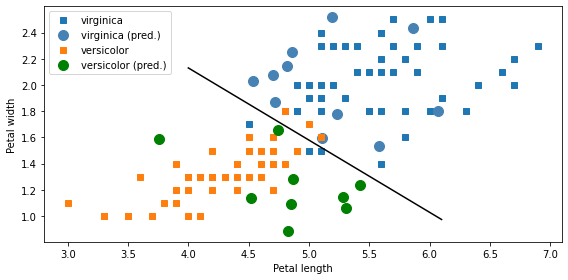

In [102]:
# 꽃잎의 길이와 너비를 독립 변수로 해 아이리스 종을 로직 회귀를 사용해 분류한 결과
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
  # virginica 종
ax.plot(df_subset[df_subset.Species == 0].Petal_Length.values,
        df_subset[df_subset.Species == 0].Petal_Width.values, 's', label='virginica')
ax.plot(df_new[df_new.Species == 0].Petal_Length.values,
        df_new[df_new.Species == 0].Petal_Width.values,
        'o', markersize=10, color="steelblue", label='virginica (pred.)')
  # versicolor 종
ax.plot(df_subset[df_subset.Species == 1].Petal_Length.values,
        df_subset[df_subset.Species == 1].Petal_Width.values, 's', label='versicolor')
ax.plot(df_new[df_new.Species == 1].Petal_Length.values,
        df_new[df_new.Species == 1].Petal_Width.values,
        'o', markersize=10, color="green", label='versicolor (pred.)')

_x = np.array([4.0, 6.1])
ax.plot(_x, alpha0 + alpha1 * _x, 'k')

ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')
ax.legend(loc=2)
fig.tight_layout()

## 푸아송 모델
이산 회귀의 또 다른 예로 낮은 성공 확률을 가진 다수의 시도 중 성공한 횟수를 반응 변수로 가진 모델을 기술하는 프로세스

In [103]:
dataset = sm.datasets.get_rdataset("discoveries")
df = dataset.data.set_index("time").rename(columns={"value": "discoveries"}) # 위대한 발견의 수
df.head(10).T

time,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869
discoveries,5,3,0,2,0,3,2,3,6,1


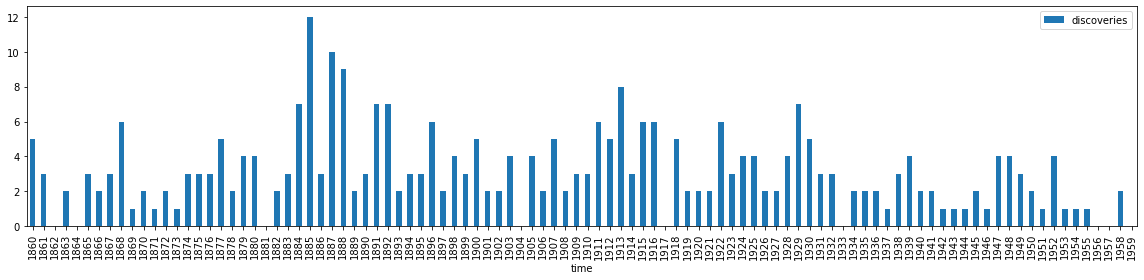

In [104]:
# 연간 발견 개수 막대그래프
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
df.plot(kind='bar', ax=ax)
fig.tight_layout()

In [105]:
# Pasty 공식을 사용해 데이터를 푸아송 프로세스에 적합화하기
model = smf.poisson("discoveries ~ 1", data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 2.168457
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:            discoveries   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Mon, 08 Aug 2022   Pseudo R-squ.:                   0.000
Time:                        04:39:38   Log-Likelihood:                -216.85
converged:                       True   LL-Null:                       -216.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1314      0.057     19.920      0.000       1.020       1.243


In [106]:
# params 속성을 통해 알 수 있는 모델 매개변수는 지수 함수를 통한 푸아송 분포의 매개변수와 연계
lmbda = np.exp(result.params) 

In [107]:
X = stats.poisson(lmbda)
# 매개 변수의 추정 신뢰 구간 구하기
result.conf_int() 

,0,1
Intercept,1.020084,1.242721


In [108]:
# 데이터의 적합성 평가를 위해 모델 매개변수 신뢰 구간의 하한과 상한에 대한 확률 변수 생성
X_ci_l = stats.poisson(np.exp(result.conf_int().values)[0, 0])
X_ci_u = stats.poisson(np.exp(result.conf_int().values)[0, 1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


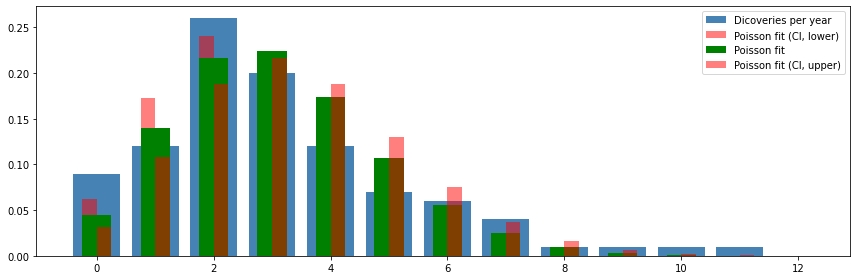

In [109]:
# 연간 위대한 발견 개수의 히스토그램과 적합화된 푸아송 모델의 확률 질량 함수의 비교
v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(k[:-1], v, color="steelblue",  align='center', label='Dicoveries per year') 
ax.bar(k-0.125, X_ci_l.pmf(k), color="red", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, lower)')
ax.bar(k, X.pmf(k), color="green",  align='center', width=0.5, label='Poisson fit')
ax.bar(k+0.125, X_ci_u.pmf(k), color="red",  alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, upper)')

ax.legend()
fig.tight_layout()

위의 결과를 보면 푸아송 확률 질량 함수와 관측된 수는 서로 현저하게 벗어나므로 위대한 발견 데이터셋은 푸아송 프로세스로 잘 설명되지 않음    
-> 특정 연도의 발견 수와 근접한 과거의 발견 수 사이에는 상관 관계가 있기 때문    
-> 시계열 분석이 나을 수도 있음

## 시계열
시간의 함수로 관측된 데이터의 미래 값을 분석하고 예측하는 통계 모델량의 중요한 분야

In [110]:
# 3월 한달 간 측정한 온도를 바탕으로 4월의 첫 3일간 시간별 온도 예측하기
df = pd.read_csv("temperature_outdoor_2014.tsv", header=None, delimiter="\t", names=["time", "temp"])
df.time = pd.to_datetime(df.time, unit="s")
df = df.set_index("time").resample("H").mean()

In [111]:
df_march = df[df.index.month == 3] # 3월 관측값
df_april = df[df.index.month == 4] # 4월 관측값

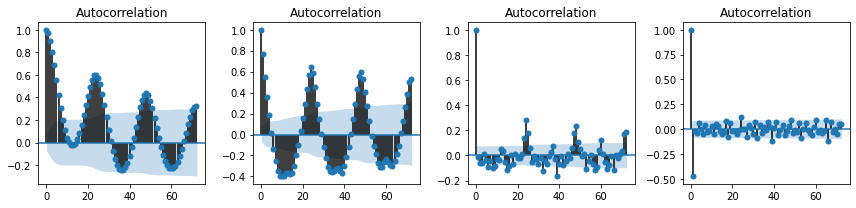

In [113]:
# 좌에서 우로 차분을 증가시켜 가면서 기온 데이터의 자기 상관 함수를 그림
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
smg.tsa.plot_acf(df_march.temp, lags=72, ax=axes[0])
smg.tsa.plot_acf(df_march.temp.diff().dropna(), lags=72, ax=axes[1])
smg.tsa.plot_acf(df_march.temp.diff().diff().dropna(), lags=72, ax=axes[2])
smg.tsa.plot_acf(df_march.temp.diff().diff().diff().dropna(), lags=72, ax=axes[3])
fig.tight_layout()

위의 그림 결과 차수가 증가되면 사계열 차분은 자기 상관 관계를 크게 감소시킴

In [114]:
# 시계열용 AR 모델 만들기
model = sm.tsa.AR(df_march.temp)
result = model.fit(72) # 3일간 -> 72시간
sm.stats.durbin_watson(result.resid) # 정상 상태 여부를 알아보는데 사용 -> 2에 가까우면 자기 상관 관계가 없다는 뜻

1.998562300635301

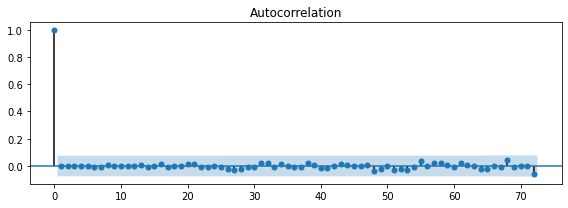

In [115]:
# 기온 관측값 AR 모델의 잔차의 자기 상관 관계 그래프
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
smg.tsa.plot_acf(result.resid, lags=72, ax=ax)
fig.tight_layout()

더빈-왓슨 통계량은 2에 가깝고 위의 그래프의 결과 자기 상관이 없으므로 적합화된 데이터를 성공적으로 설명함

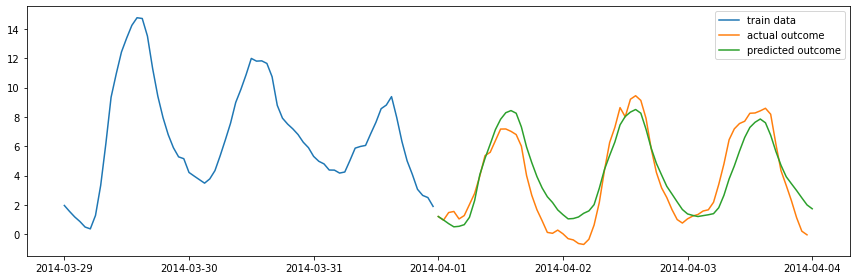

In [116]:
# 미래 날짜 기온 예측하기
# 녹색 : 실제
# 빨간색: 예측
temp_3d_forecast = result.predict("2014-04-01", "2014-04-4")
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_march.index.values[-72:], df_march.temp.values[-72:], label="train data")
ax.plot(df_april.index.values[:72], df_april.temp.values[:72], label="actual outcome")
ax.plot(pd.date_range("2014-04-01", "2014-04-4", freq="H").values,
        result.predict("2014-04-01", "2014-04-4"), label="predicted outcome")

ax.legend()
fig.tight_layout()